# Process bulk counts table

1. Annotate columns (samples) in a way that time point and replicate are annotated
2. Remove rRNA genes
3. Perform TPM normalization and alternatively also raw counts

In [1]:
# Use miniconda environment Jupyter_new for running this notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from tools import *
import warnings
warnings.filterwarnings('ignore')

## 1 Load the dataset and annotation

In [2]:
bulkPath = '../nf_output/countData/countData.tsv'
metaPath = '../SraRunTable.csv' # metadata from SRA
gffPath = '../nf_output/alignments/dualGenome.gff3' # output from nf pipeline

In [3]:
# Load and filter data
df_initial = pd.read_csv(bulkPath, sep = '\t', comment='#', index_col=0)
df_initial.drop(columns=[f"SRR277237{i:02d}_sorted.bam" for i in range(40, 52)], inplace=True)
metadata = pd.read_csv(metaPath)
metadata = metadata[metadata['cell_state'] == 'stationary']

In [4]:
[f"SRR277237{i:02d}_sorted.bam" for i in range(40, 52)]

['SRR27723740_sorted.bam',
 'SRR27723741_sorted.bam',
 'SRR27723742_sorted.bam',
 'SRR27723743_sorted.bam',
 'SRR27723744_sorted.bam',
 'SRR27723745_sorted.bam',
 'SRR27723746_sorted.bam',
 'SRR27723747_sorted.bam',
 'SRR27723748_sorted.bam',
 'SRR27723749_sorted.bam',
 'SRR27723750_sorted.bam',
 'SRR27723751_sorted.bam']

In [5]:
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', 20)
metadata

,Run,assay,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,Bytes,cell_state,Center Name,Collection_Date,Consent,DATASTORE filetype,DATASTORE provider,DATASTORE region,Experiment,geo_loc_name_country,geo_loc_name_country_continent,geo_loc_name,Instrument,Library Name,LibraryLayout,LibrarySelection,LibrarySource,moi,Organism,Platform,ReleaseDate,create_date,version,Sample Name,source_name,SRA Study,strain,time,treatment
0,SRR27723728,3,RNA-Seq,300,3299120700,PRJNA1068994,SAMN39608882,1070441504,stationary,"CENTRE OF BIOLOGICAL ENGINEERING, UNIVERSITY O...",missing,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX23389683,uncalculated,uncalculated,missing,Illumina NovaSeq 6000,GSM8035786,PAIRED,cDNA,TRANSCRIPTOMIC,5,Staphylococcus epidermidis,ILLUMINA,2024-05-15T00:00:00Z,2024-01-25T14:50:00Z,1,GSM8035786,9142,SRP485903,9142,30 min,Staphylococcus phage phiIBB-SEP1
1,SRR27723729,3,RNA-Seq,300,2731917900,PRJNA1068994,SAMN39608883,928095421,stationary,"CENTRE OF BIOLOGICAL ENGINEERING, UNIVERSITY O...",missing,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX23389682,uncalculated,uncalculated,missing,Illumina NovaSeq 6000,GSM8035785,PAIRED,cDNA,TRANSCRIPTOMIC,5,Staphylococcus epidermidis,ILLUMINA,2024-05-15T00:00:00Z,2024-01-25T14:50:00Z,1,GSM8035785,9142,SRP485903,9142,15 min,Staphylococcus phage phiIBB-SEP1
2,SRR27723730,3,RNA-Seq,300,3283898700,PRJNA1068994,SAMN39608884,1092318179,stationary,"CENTRE OF BIOLOGICAL ENGINEERING, UNIVERSITY O...",missing,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX23389681,uncalculated,uncalculated,missing,Illumina NovaSeq 6000,GSM8035784,PAIRED,cDNA,TRANSCRIPTOMIC,5,Staphylococcus epidermidis,ILLUMINA,2024-05-15T00:00:00Z,2024-01-25T14:51:00Z,1,GSM8035784,9142,SRP485903,9142,5 min,Staphylococcus phage phiIBB-SEP1
3,SRR27723731,3,RNA-Seq,300,3308322600,PRJNA1068994,SAMN39608885,1088072858,stationary,"CENTRE OF BIOLOGICAL ENGINEERING, UNIVERSITY O...",missing,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX23389680,uncalculated,uncalculated,missing,Illumina NovaSeq 6000,GSM8035783,PAIRED,cDNA,TRANSCRIPTOMIC,0,Staphylococcus epidermidis,ILLUMINA,2024-05-15T00:00:00Z,2024-01-25T14:50:00Z,1,GSM8035783,9142,SRP485903,9142,0 min,No treatment
4,SRR27723732,2,RNA-Seq,300,3352624500,PRJNA1068994,SAMN39608886,1122712532,stationary,"CENTRE OF BIOLOGICAL ENGINEERING, UNIVERSITY O...",missing,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX23389679,uncalculated,uncalculated,missing,Illumina NovaSeq 6000,GSM8035782,PAIRED,cDNA,TRANSCRIPTOMIC,5,Staphylococcus epidermidis,ILLUMINA,2024-05-15T00:00:00Z,2024-01-25T14:52:00Z,1,GSM8035782,9142,SRP485903,9142,30 min,Staphylococcus phage phiIBB-SEP1
5,SRR27723733,2,RNA-Seq,300,3501969300,PRJNA1068994,SAMN39608887,1165456941,stationary,"CENTRE OF BIOLOGICAL ENGINEERING, UNIVERSITY O...",missing,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX23389678,uncalculated,uncalculated,missing,Illumina NovaSeq 6000,GSM8035781,PAIRED,cDNA,TRANSCRIPTOMIC,5,Staphylococcus epidermidis,ILLUMINA,2024-05-15T00:00:00Z,2024-01-25T14:51:00Z,1,GSM8035781,9142,SRP485903,9142,15 min,Staphylococcus phage phiIBB-SEP1
6,SRR27723734,2,RNA-Seq,300,3063028200,PRJNA1068994,SAMN39608888,998532361,stationary,"CENTRE OF BIOLOGICAL ENGINEERING, UNIVERSITY O...",missing,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX23389677,uncalculated,uncalculated,missing,Illumina NovaSeq 6000,GSM8035780,PAIRED,cDNA,TRANSCRIPTOMIC,5,Staphylococcus epidermidis,ILLUMINA,2024-05-15T00:00:00Z,2024-01-25T14:50:00Z,1,GSM8035780,9142,SRP485903,9142,5 min,Staphylococcus phage phiIBB-SEP1
7,SRR27723735,2,RNA-Seq,300,3247767300,PRJNA1068994,SAMN39608889,1065024989,stationary,"CENTRE OF BIOLOGICAL ENGINEERING, UNIVERSITY O...",missing,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.

## 2 Format the dataset

### 2.1 Annotate sample names

Issue now is that the metadata does not properly annotate sample names. Thus, this will be done manually by adding another sample name column to the metadata.

In [6]:
# Match GSM IDs and SampleNames inferred from GEO

sampleDict = {'GSM8035775': '0_R1', 'GSM8035776': '5_R1', 'GSM8035777': '15_R1', 'GSM8035778': '30_R1',
              'GSM8035779': '0_R2', 'GSM8035780': '5_R2', 'GSM8035781': '15_R2', 'GSM8035782': '30_R2',
              'GSM8035783': '0_R3', 'GSM8035784': '5_R3', 'GSM8035785': '15_R3', 'GSM8035786': '30_R3'
}

In [7]:
metadataFull = annotateData(metadata, sampleDict)

In [8]:
metadata.head(1)

,Run,assay,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,Bytes,cell_state,Center Name,Collection_Date,Consent,DATASTORE filetype,DATASTORE provider,DATASTORE region,Experiment,geo_loc_name_country,geo_loc_name_country_continent,geo_loc_name,Instrument,Library Name,LibraryLayout,LibrarySelection,LibrarySource,moi,Organism,Platform,ReleaseDate,create_date,version,Sample Name,source_name,SRA Study,strain,time,treatment
0,SRR27723728,3,RNA-Seq,300,3299120700,PRJNA1068994,SAMN39608882,1070441504,stationary,"CENTRE OF BIOLOGICAL ENGINEERING, UNIVERSITY O...",missing,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX23389683,uncalculated,uncalculated,missing,Illumina NovaSeq 6000,GSM8035786,PAIRED,cDNA,TRANSCRIPTOMIC,5,Staphylococcus epidermidis,ILLUMINA,2024-05-15T00:00:00Z,2024-01-25T14:50:00Z,1,GSM8035786,9142,SRP485903,9142,30 min,Staphylococcus phage phiIBB-SEP1


In [9]:
metadataFull.head(1)

,Run,assay,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,Bytes,cell_state,Center Name,Collection_Date,Consent,DATASTORE filetype,DATASTORE provider,DATASTORE region,Experiment,geo_loc_name_country,geo_loc_name_country_continent,geo_loc_name,Instrument,Library Name,LibraryLayout,LibrarySelection,LibrarySource,moi,Organism,Platform,ReleaseDate,create_date,version,Sample Name,source_name,SRA Study,strain,time,treatment,SampleID,SampleNames
SampleID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
SRR27723728_sorted.bam,SRR27723728,3,RNA-Seq,300,3299120700,PRJNA1068994,SAMN39608882,1070441504,stationary,"CENTRE OF BIOLOGICAL ENGINEERING, UNIVERSITY O...",missing,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX23389683,uncalculated,uncalculated,missing,Illumina NovaSeq 6000,GSM8035786,PAIRED,cDNA,TRANSCRIPTOMIC,5,Staphylococcus epidermidis,ILLUMINA,2024-05-15T00:00:00Z,2024-01-25T14:50:00Z,1,GSM8035786,9142,SRP485903,9142,30 min,Staphylococcus phage phiIBB-SEP1,SRR27723728_sorted.bam,30_R3


Add correct sample names.

In [10]:
df_initial.head()

,Chr,Start,End,Strand,Length,SRR27723734_sorted.bam,SRR27723739_sorted.bam,SRR27723738_sorted.bam,SRR27723729_sorted.bam,SRR27723736_sorted.bam,SRR27723728_sorted.bam,SRR27723733_sorted.bam,SRR27723735_sorted.bam,SRR27723731_sorted.bam,SRR27723730_sorted.bam,SRR27723732_sorted.bam,SRR27723737_sorted.bam
Geneid,,,,,,,,,,,,,,,,,
gene-SERP0001,CP000029.1,540,677,+,138,2113,89,1120,2437,1483,2971,2013,589,185,595,5880,1533
gene-SERP0002,CP000029.1,836,1183,+,348,129,14,163,133,205,423,176,58,59,68,345,219
gene-SERP0003,CP000029.1,1329,2708,+,1380,2168,266,1747,2294,1258,3293,2786,841,1141,905,3300,1767
gene-SERP0004,CP000029.1,2781,4658,+,1878,1792,1170,1273,1759,1668,3239,2203,1515,1700,1208,3238,2529
gene-SERP0005,CP000029.1,4658,5377,+,720,959,808,658,873,863,1967,1172,1088,994,919,1953,1464


In [11]:
metadataFull

,Run,assay,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,Bytes,cell_state,Center Name,Collection_Date,Consent,DATASTORE filetype,DATASTORE provider,DATASTORE region,Experiment,geo_loc_name_country,geo_loc_name_country_continent,geo_loc_name,Instrument,Library Name,LibraryLayout,LibrarySelection,LibrarySource,moi,Organism,Platform,ReleaseDate,create_date,version,Sample Name,source_name,SRA Study,strain,time,treatment,SampleID,SampleNames
SampleID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
SRR27723728_sorted.bam,SRR27723728,3,RNA-Seq,300,3299120700,PRJNA1068994,SAMN39608882,1070441504,stationary,"CENTRE OF BIOLOGICAL ENGINEERING, UNIVERSITY O...",missing,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX23389683,uncalculated,uncalculated,missing,Illumina NovaSeq 6000,GSM8035786,PAIRED,cDNA,TRANSCRIPTOMIC,5,Staphylococcus epidermidis,ILLUMINA,2024-05-15T00:00:00Z,2024-01-25T14:50:00Z,1,GSM8035786,9142,SRP485903,9142,30 min,Staphylococcus phage phiIBB-SEP1,SRR27723728_sorted.bam,30_R3
SRR27723729_sorted.bam,SRR27723729,3,RNA-Seq,300,2731917900,PRJNA1068994,SAMN39608883,928095421,stationary,"CENTRE OF BIOLOGICAL ENGINEERING, UNIVERSITY O...",missing,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX23389682,uncalculated,uncalculated,missing,Illumina NovaSeq 6000,GSM8035785,PAIRED,cDNA,TRANSCRIPTOMIC,5,Staphylococcus epidermidis,ILLUMINA,2024-05-15T00:00:00Z,2024-01-25T14:50:00Z,1,GSM8035785,9142,SRP485903,9142,15 min,Staphylococcus phage phiIBB-SEP1,SRR27723729_sorted.bam,15_R3
SRR27723730_sorted.bam,SRR27723730,3,RNA-Seq,300,3283898700,PRJNA1068994,SAMN39608884,1092318179,stationary,"CENTRE OF BIOLOGICAL ENGINEERING, UNIVERSITY O...",missing,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX23389681,uncalculated,uncalculated,missing,Illumina NovaSeq 6000,GSM8035784,PAIRED,cDNA,TRANSCRIPTOMIC,5,Staphylococcus epidermidis,ILLUMINA,2024-05-15T00:00:00Z,2024-01-25T14:51:00Z,1,GSM8035784,9142,SRP485903,9142,5 min,Staphylococcus phage phiIBB-SEP1,SRR27723730_sorted.bam,5_R3
SRR27723731_sorted.bam,SRR27723731,3,RNA-Seq,300,3308322600,PRJNA1068994,SAMN39608885,1088072858,stationary,"CENTRE OF BIOLOGICAL ENGINEERING, UNIVERSITY O...",missing,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX23389680,uncalculated,uncalculated,missing,Illumina NovaSeq 6000,GSM8035783,PAIRED,cDNA,TRANSCRIPTOMIC,0,Staphylococcus epidermidis,ILLUMINA,2024-05-15T00:00:00Z,2024-01-25T14:50:00Z,1,GSM8035783,9142,SRP485903,9142,0 min,No treatment,SRR27723731_sorted.bam,0_R3
SRR27723732_sorted.bam,SRR27723732,2,RNA-Seq,300,3352624500,PRJNA1068994,SAMN39608886,1122712532,stationary,"CENTRE OF BIOLOGICAL ENGINEERING, UNIVERSITY O...",missing,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX23389679,uncalculated,uncalculated,missing,Illumina NovaSeq 6000,GSM8035782,PAIRED,cDNA,TRANSCRIPTOMIC,5,Staphylococcus epidermidis,ILLUMINA,2024-05-15T00:00:00Z,2024-01-25T14:52:00Z,1,GSM8035782,9142,SRP485903,9142,30 min,Staphylococcus phage phiIBB-SEP1,SRR27723732_sorted.bam,30_R2
SRR27723733_sorted.bam,SRR27723733,2,RNA-Seq,300,3501969300,PRJNA1068994,SAMN39608887,1165456941,stationary,"CENTRE OF BIOLOGICAL ENGINEERING, UNIVERSITY O...",missing,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX23389678,uncalculated,uncalculated,missing,Illumina NovaSeq 6000,GSM8035781,PAIRED,cDNA,TRANSCRIPTOMIC,5,Staphylococcus epidermidis,ILLUMINA,2024-05-15T00:00:00Z,2024-01-25T14:51:00Z,1,GSM8035781,9142,SRP485903,9142,15 min,Staphylococcus phage phiIBB-SEP1,SRR27723733_sorted.bam,15_R2
SRR27723734_sorted.bam,SRR27723734,2,RNA-Seq,300,3063028200,PRJNA1068994,SAMN39608888,998532361,stationary,"CENTRE OF BIOLOGICAL ENGINEERING, UNIVERSITY O...",missing,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX23389677,uncalculated,uncalculated,missing,Illumina NovaSeq 6000,GSM8035780,PAIRED

In [12]:
df = changeColnames(df_initial.iloc[:,5:df_initial.shape[1]], metadataFull)
df = df[['0_R1', '0_R2', '0_R3', '5_R1', '5_R2', '5_R3', '15_R1', '15_R2', '15_R3', '30_R1', '30_R2', '30_R3']]
df.head()

SampleNames,0_R1,0_R2,0_R3,5_R1,5_R2,5_R3,15_R1,15_R2,15_R3,30_R1,30_R2,30_R3
Geneid,,,,,,,,,,,,
gene-SERP0001,89,589,185,1120,2113,595,1533,2013,2437,1483,5880,2971
gene-SERP0002,14,58,59,163,129,68,219,176,133,205,345,423
gene-SERP0003,266,841,1141,1747,2168,905,1767,2786,2294,1258,3300,3293
gene-SERP0004,1170,1515,1700,1273,1792,1208,2529,2203,1759,1668,3238,3239
gene-SERP0005,808,1088,994,658,959,919,1464,1172,873,863,1953,1967


### 2.2 Remove rRNA genes

Consult gff3 file to get rRNA geneids.

In [13]:
# Load gff3 and split into genes and CDS dfs
gff3 = pd.read_csv(gffPath, sep='\t', header = None, skiprows = 5)
gff3.columns=["seq_id", "source", "type", "start", "end", "phase", "strand", "score", "attributes"]
gff3_genes = gff3.loc[gff3["type"] == 'gene']

# Column formating for genes
gff3_genes = gff3_genes.reset_index(drop=True)
dct_genes = gff3_genes["attributes"].str.split(';').apply(lambda items: dict(item.split('=', 1) for item in items if '=' in item))
cols_to_keep = ['ID', 'Name', 'gbkey', 'gene_biotype', 'locus_tag', 'gene']
gff3_genes = pd.concat([gff3_genes, pd.json_normalize(dct_genes)[cols_to_keep]], axis=1)

# Generate locus_tag, product dictonary over all different feature types
attrs = gff3["attributes"].str.split(";", expand=True)
attrs_dicts = attrs.apply(lambda row: {item.split("=")[0]: item.split("=")[1] for item in row if "=" in str(item)}, axis=1)
attrs_df = pd.json_normalize(attrs_dicts)
attrs_df = attrs_df.dropna(subset=["locus_tag", "product"])
locus_product_dict = dict(zip(attrs_df["locus_tag"], attrs_df["product"]))

# Add gene product, if not stated in gff3, fill with gene_biotype
gff3_genes["product"] = gff3_genes["locus_tag"].map(locus_product_dict)
# gff3_genes["product"] = gff3_genes["product"].fillna("other")
gff3_genes["product"] = gff3_genes["product"].fillna(gff3_genes["gene_biotype"])

# If gene = NA, take from ID column
gff3_genes["gene"] = gff3_genes["gene"].fillna(gff3_genes["ID"])

# Drop attributes column
gff3_genes = gff3_genes.drop(["attributes"], axis=1)

In [14]:
pharokka_path = "../../../2025-12_reannotation_phage_genomes/Pharokka_proteins_phages_out/NC_041928.1_out/pharokka_proteins_full_merged_output.tsv"
gff3_genes = add_pharokka(gff3_genes, pharokka_path)
gff3_genes.loc[gff3_genes['seq_id'] == "NC_041928.1"]

,seq_id,source,type,start,end,phase,strand,score,ID,Name,gbkey,gene_biotype,locus_tag,gene,product,annot,PHROG,category
2577,NC_041928.1,RefSeq,gene,1.0,3507.0,.,+,.,gene-FDH45_gp001,FDH45_gp001,Gene,protein_coding,FDH45_gp001,gene-FDH45_gp001,terminase large subunit,terminase large subunit,675,head and packaging
2578,NC_041928.1,RefSeq,gene,472.0,1443.0,.,+,.,gene-FDH45_gp002,FDH45_gp002,Gene,protein_coding,FDH45_gp002,gene-FDH45_gp002,HNH endonuclease,HNH endonuclease,559,"DNA, RNA and nucleotide metabolism"
2579,NC_041928.1,RefSeq,gene,3521.0,4324.0,.,+,.,gene-FDH45_gp003,FDH45_gp003,Gene,protein_coding,FDH45_gp003,gene-FDH45_gp003,virion structural protein,virion structural protein,1917,head and packaging
2580,NC_041928.1,RefSeq,gene,4311.0,4472.0,.,+,.,gene-FDH45_gp004,FDH45_gp004,Gene,protein_coding,FDH45_gp004,gene-FDH45_gp004,hypothetical protein,hypothetical protein,38741,unknown function
2581,NC_041928.1,RefSeq,gene,4486.0,4977.0,.,+,.,gene-FDH45_gp005,FDH45_gp005,Gene,protein_coding,FDH45_gp005,gene-FDH45_gp005,hypothetical protein,hypothetical protein,1116,unknown function
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2772,NC_041928.1,RefSeq,gene,138161.0,138484.0,.,-,.,gene-FDH45_gp196,FDH45_gp196,Gene,protein_coding,FDH45_gp196,gene-FDH45_gp196,hypothetical protein,hypothetical protein,1481,unknown function
2773,NC_041928.1,RefSeq,gene,138563.0,138772.0,.,-,.,gene-FDH45_gp197,FDH45_gp197,Gene,protein_coding,FDH45_gp197,gene-FDH45_gp197,hypothetical protein,hypothetical protein,No_PHROG,unknown function
2774,NC_041928.1,RefSeq,gene,138891.0,139250.0,.,+,.,gene-FDH45_gp198,FDH45_gp198,Gene,protein_coding,FDH45_gp198,gene-FDH45_gp198,membrane protein,membrane protein,3395,"moron, auxiliary metabolic gene and host takeover"
2775,NC_041928.1,RefSeq,gene,139231.0,139494.0,.,+,.,gene-FDH45_gp199,FDH45_gp199,Gene,protein_coding,FDH45_gp199,gene-FDH45_gp199,hypothetical protein,hypothetical protein,1321,unknown function


In [15]:
# Load ggf3 file

gff3 = pd.read_csv(gffPath, sep='\t', header = None, skiprows = 5)
gff3 = gff3.loc[gff3.iloc[:,2] == 'gene']

# Format some new columns
gff3['ID'] = pd.DataFrame(gff3.iloc[:,8].str.split('ID=', expand = True)).iloc[:,1].str.split(';', expand = True).iloc[:,0]
gff3['GeneType'] = pd.DataFrame(gff3.iloc[:,8].str.split('gene_biotype=', expand = True)).iloc[:,1].str.split(';', expand = True).iloc[:,0]
gff3['Symbol'] = pd.DataFrame(gff3.iloc[:,8].str.split('gene=', expand = True)).iloc[:,1].str.split(';', expand = True).iloc[:,0]

# Add entity host and phage
gff3['Entity'] = np.where(gff3[0] == 'CP000029.1', 'host', 'phage')
gff3.index = gff3['ID']
rRNAs = gff3.loc[gff3['GeneType'] == 'rRNA', 'ID'].tolist()

In [16]:
gff3

,0,1,2,3,4,5,6,7,8,ID,GeneType,Symbol,Entity
ID,,,,,,,,,,,,,
gene-SERP0001,CP000029.1,Genbank,gene,540.0,677.0,.,+,.,ID=gene-SERP0001;Name=rpmH;gbkey=Gene;gene=rpm...,gene-SERP0001,protein_coding,rpmH,host
gene-SERP0002,CP000029.1,Genbank,gene,836.0,1183.0,.,+,.,ID=gene-SERP0002;Name=rnpA;gbkey=Gene;gene=rnp...,gene-SERP0002,protein_coding,rnpA,host
gene-SERP0003,CP000029.1,Genbank,gene,1329.0,2708.0,.,+,.,ID=gene-SERP0003;Name=trmE;gbkey=Gene;gene=trm...,gene-SERP0003,protein_coding,trmE,host
gene-SERP0004,CP000029.1,Genbank,gene,2781.0,4658.0,.,+,.,ID=gene-SERP0004;Name=gidA;gbkey=Gene;gene=gid...,gene-SERP0004,protein_coding,gidA,host
gene-SERP0005,CP000029.1,Genbank,gene,4658.0,5377.0,.,+,.,ID=gene-SERP0005;Name=gidB;gbkey=Gene;gene=gid...,gene-SERP0005,protein_coding,gidB,host
...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-FDH45_gp196,NC_041928.1,RefSeq,gene,138161.0,138484.0,.,-,.,ID=gene-FDH45_gp196;Dbxref=GeneID:40076955;Nam...,gene-FDH45_gp196,protein_coding,None,phage
gene-FDH45_gp197,NC_041928.1,RefSeq,gene,138563.0,138772.0,.,-,.,ID=gene-FDH45_gp197;Dbxref=GeneID:40076956;Nam...,gene-FDH45_gp197,protein_coding,None,phage
gene-FDH45_gp198,NC_041928.1,RefSeq,gene,138891.0,139250.0,.,+,.,ID=gene-FDH45_gp198;Dbxref=GeneID:40076957;Nam...,gene-FDH45_gp198,protein_coding,None,phage


Perform in silico rRNA depletion.

In [17]:
df_norRNAs = rRNAdepletion(df,rRNAs)
df_norRNAs.head()

SampleNames,0_R1,0_R2,0_R3,5_R1,5_R2,5_R3,15_R1,15_R2,15_R3,30_R1,30_R2,30_R3
Geneid,,,,,,,,,,,,
gene-SERP0198,18,42,26,59,37,35,38,38,26,12,32,41
gene-SERP0459,4,7,3,7,6,3,3,3,3,2,2,5
gene-SERP1154,28,129,111,442,432,165,318,409,439,204,550,584
gene-SERP0208,756,478,330,1376,382,615,506,259,388,169,240,309
gene-SERP2485,19,17,9,25,12,12,23,26,15,7,25,36


### 2.3 Read count normalization

Important note: gene symbols not available for most genes.

In [18]:
# Function to fill in missing symbols by geneid.

def fillSymbols(df):
    df_new = df.copy()
    index = df.index.to_list()
    for i in range(0,df.shape[0]):
        if (df.iloc[i,-1:].values == None):
            df_new.iloc[i,-1:] = index[i]
    return df_new

Convert counts to TPM.

In [19]:
tpms = TPM(df_norRNAs, df_initial, 0.5)
tpms['Entity'] = gff3.loc[sorted(tpms.index.to_list()), 'Entity']
tpms['Symbol'] = gff3.loc[sorted(tpms.index.to_list()), 'Symbol']

tpms = fillSymbols(tpms)
tpms = make_unique_with_index(tpms)
tpms

SampleNames,0_R1,0_R2,0_R3,5_R1,5_R2,5_R3,15_R1,15_R2,15_R3,30_R1,30_R2,30_R3,Entity,Symbol
Geneid,,,,,,,,,,,,,,
gene-SERP0198,0.369029,0.937221,0.551727,0.987526,0.772523,0.671293,0.491430,0.689382,0.478955,0.203364,0.522716,0.689535,host,gene-SERP0198
gene-SERP0459,1.584892,2.920202,1.286604,2.197816,2.364242,1.168557,0.788800,1.106536,1.116902,0.718131,0.709938,1.613502,host,gene-SERP0459
gene-SERP1154,0.988323,4.964643,4.035695,12.767623,15.489279,5.440598,7.067650,12.747298,13.809329,5.783936,15.392338,16.883329,host,gene-SERP1154
gene-SERP0208,17.017996,11.899969,7.759979,25.764316,8.886325,13.125696,7.291060,5.240192,7.918635,3.109893,4.362224,5.799357,host,gene-SERP0208
gene-SERP2485,1.181568,1.172268,0.600810,1.285604,0.782214,0.718008,0.911179,1.441387,0.850973,0.370648,1.245827,1.842200,host,kdpC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-SERP1919,963.451929,212.151434,261.600031,529.384468,109.324020,157.434222,178.505786,133.319379,71.236263,74.994949,32.606196,41.356813,host,hutG
gene-SERP2067,4.735661,5.761801,4.408912,13.273573,8.351547,5.392136,4.587844,8.794898,8.349923,2.006720,3.846777,3.665444,host,gene-SERP2067
gene-SERP0559,0.108369,0.119803,0.791756,0.811501,4.140920,0.719112,0.346725,1.653725,2.258352,1.325780,3.058196,2.076115,host,gene-SERP0559


In [20]:
# Check gene names unique
len(tpms['Symbol'].unique())

2758

Log2+1 normalization raw counts

In [21]:
logs = logNorm(df_norRNAs)
logs['Entity'] = gff3.loc[sorted(logs.index.to_list()), 'Entity']
logs['Symbol'] = gff3.loc[sorted(logs.index.to_list()), 'Symbol']
logs = fillSymbols(logs)
# Make gene names unique
logs = make_unique_with_index(logs)
logs

SampleNames,0_R1,0_R2,0_R3,5_R1,5_R2,5_R3,15_R1,15_R2,15_R3,30_R1,30_R2,30_R3,Entity,Symbol
Geneid,,,,,,,,,,,,,,
gene-SERP0198,4.247928,5.426265,4.754888,5.906891,5.247928,5.169925,5.285402,5.285402,4.754888,3.700440,5.044394,5.392317,host,gene-SERP0198
gene-SERP0459,2.321928,3.000000,2.000000,3.000000,2.807355,2.000000,2.000000,2.000000,2.000000,1.584963,1.584963,2.584963,host,gene-SERP0459
gene-SERP1154,4.857981,7.022368,6.807355,8.791163,8.758223,7.375039,8.317413,8.679480,8.781360,7.679480,9.105909,9.192293,host,gene-SERP1154
gene-SERP0208,9.564149,8.903882,8.370687,10.427313,8.581201,9.266787,8.985842,8.022368,8.603626,7.409391,7.912889,8.276124,host,gene-SERP0208
gene-SERP2485,4.321928,4.169925,3.321928,4.700440,3.700440,3.700440,4.584963,4.754888,4.000000,3.000000,4.700440,5.209453,host,kdpC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-SERP1919,14.703038,12.375311,12.760512,14.104435,11.517177,12.166791,12.914946,12.005625,11.088126,11.314017,10.129283,10.425216,host,hutG
gene-SERP2067,8.071462,8.209453,7.906891,9.821774,8.842350,8.335390,8.668885,9.118941,9.030667,7.129283,8.082149,7.965784,host,gene-SERP2067
gene-SERP0559,0.000000,0.000000,2.000000,2.321928,4.247928,2.000000,1.584963,3.169925,3.584963,3.000000,4.169925,3.584963,host,gene-SERP0559


Log2+1 normalization tpms

In [22]:
logTPMs = logNorm(tpms.iloc[:, :-2])
logTPMs = logTPMs.join(tpms.iloc[:, -2:])
logTPMs = fillSymbols(logTPMs)
# Make gene names unique
logTPMs = make_unique_with_index(logTPMs)
logTPMs

SampleNames,0_R1,0_R2,0_R3,5_R1,5_R2,5_R3,15_R1,15_R2,15_R3,30_R1,30_R2,30_R3,Entity,Symbol
Geneid,,,,,,,,,,,,,,
gene-SERP0198,0.453153,0.953989,0.633875,0.990974,0.825804,0.740964,0.576696,0.756495,0.564578,0.267074,0.606647,0.756627,host,gene-SERP0198
gene-SERP0459,1.370104,1.970928,1.193206,1.677087,1.750281,1.116736,0.838992,1.074873,1.081955,0.780840,0.773944,1.385985,host,gene-SERP0459
gene-SERP1154,0.991552,2.576436,2.332191,3.783208,4.043456,2.687195,3.012149,3.781076,3.888434,2.762122,4.034950,4.160543,host,gene-SERP1154
gene-SERP0208,4.171367,3.689296,3.130927,4.742239,3.305434,3.820250,3.051557,2.641590,3.156823,2.039101,2.422832,2.765398,host,gene-SERP0208
gene-SERP2485,1.125366,1.119202,0.678802,1.192576,0.833670,0.780736,0.934463,1.287701,0.888284,0.454858,1.167247,1.507008,host,kdpC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-SERP1919,9.913566,7.735735,8.036723,9.050895,6.785603,7.307740,7.487887,7.069524,6.174651,6.247832,5.070655,5.404522,host,hutG
gene-SERP2067,2.519960,2.757408,2.435338,3.835275,3.225205,2.676298,2.482292,3.292030,3.224955,1.588191,2.277026,2.222014,host,gene-SERP2067
gene-SERP0559,0.148438,0.163245,0.841374,0.857186,2.362027,0.781664,0.429456,1.408019,1.704142,1.217715,2.020839,1.621109,host,gene-SERP0559


## 3 Filter samples, if necessary

Look for outliers visually by PCA.

In [23]:
columnOrder = ['0_R1', '0_R2', '0_R3', '5_R1', '5_R2', '5_R3', '15_R1', '15_R2', '15_R3', '30_R1', '30_R2', '30_R3']

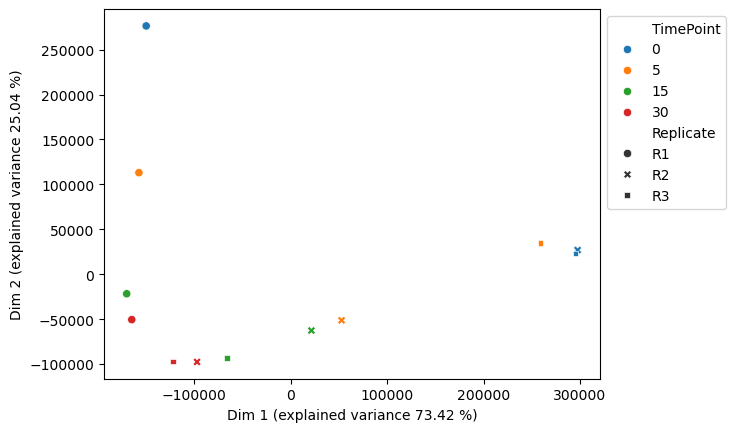

In [24]:
txPCA(tpms[columnOrder])

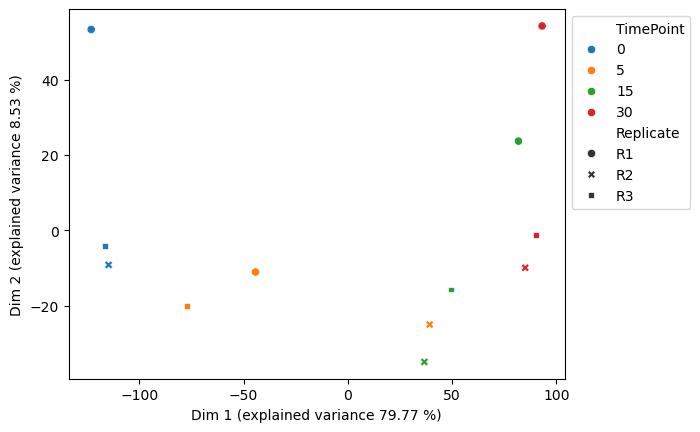

In [25]:
txPCA(logs[columnOrder])

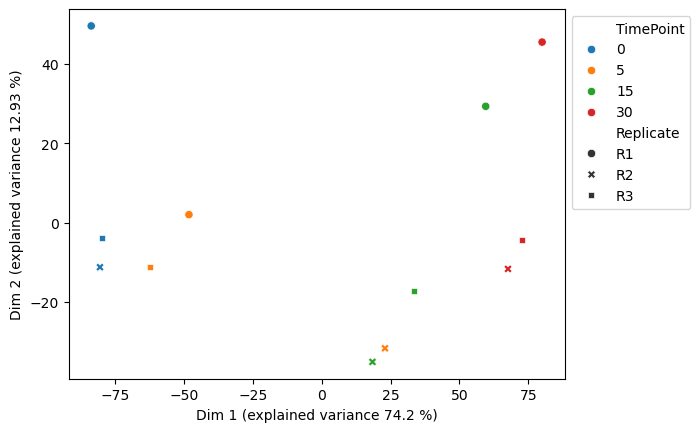

In [26]:
txPCA(logTPMs[columnOrder])

In [27]:
tpmHost = tpms[tpms['Entity'] == 'host']
tpmPhage = tpms[tpms['Entity'] == 'phage']
logTPMsHost = logTPMs[logTPMs['Entity'] == 'host']
logTPMsPhage = logTPMs[logTPMs['Entity'] == 'phage']

tpmHost

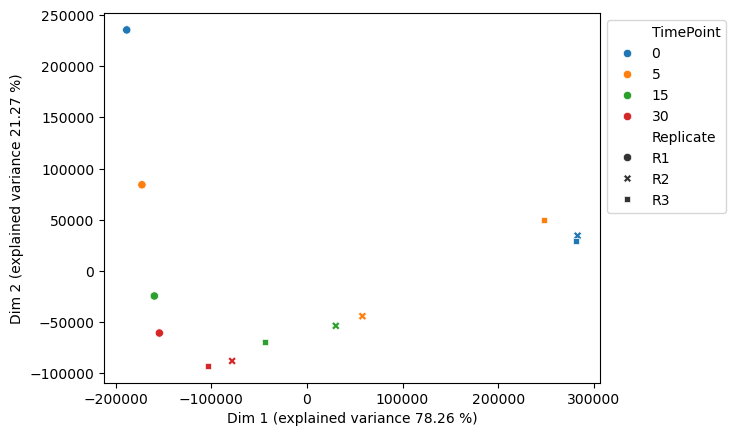

In [28]:
txPCA(tpmHost[columnOrder])

tpmPhage

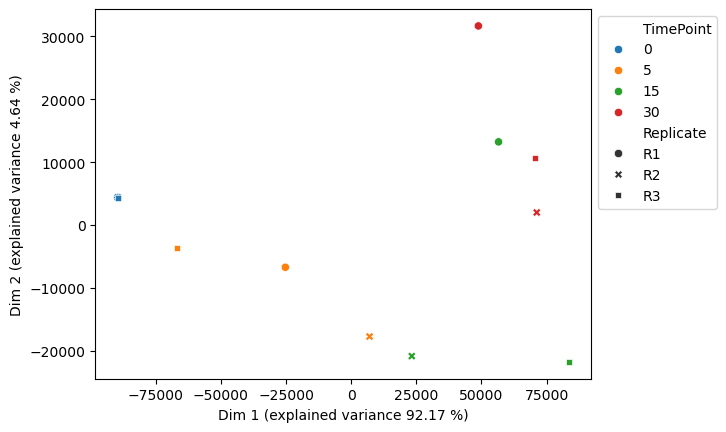

In [29]:
txPCA(tpmPhage[columnOrder])

logTPM Host

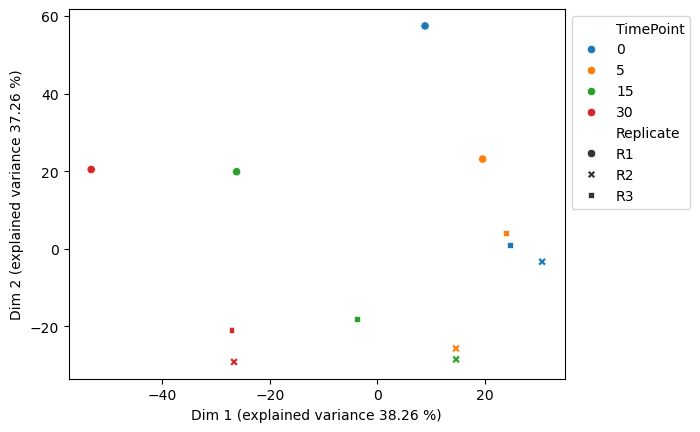

In [30]:
txPCA(logTPMsHost[columnOrder])

logTPM Phage

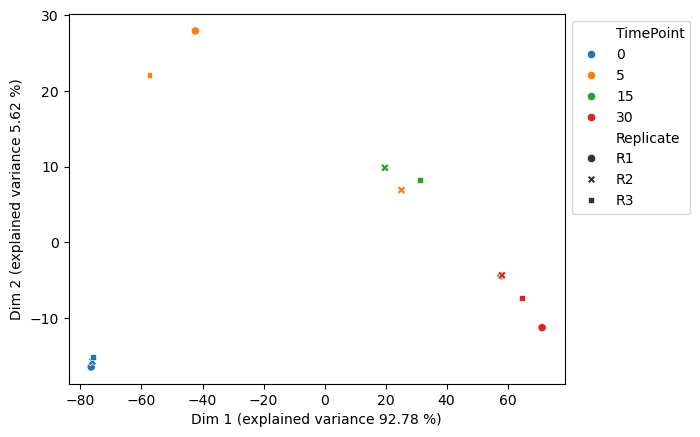

In [31]:
txPCA(logTPMsPhage[columnOrder])

$\rightarrow$ Authors used all replicates, so we as well.

## 4. Final grouping

Summarize time points with mean and standard deviation for TPM-normalized data.

In [32]:
TPMmeans, TPMsds = getMeanSD(tpms[columnOrder])
TPMmeans = TPMmeans[['0', '5', '15', '30']]
TPMmeans[['Entity', 'Symbol']] = tpms[['Entity', 'Symbol']]
TPMmeans

,0,5,15,30,Entity,Symbol
Geneid,,,,,,
gene-SERP0198,0.619326,0.810447,0.553255,0.471872,host,gene-SERP0198
gene-SERP0459,1.930566,1.910205,1.004080,1.013857,host,gene-SERP0459
gene-SERP1154,3.329553,11.232500,11.208092,12.686534,host,gene-SERP1154
gene-SERP0208,12.225981,15.925445,6.816629,4.423825,host,gene-SERP0208
gene-SERP2485,0.984882,0.928609,1.067846,1.152892,host,kdpC
...,...,...,...,...,...,...
gene-SERP1919,479.067798,265.380903,127.687142,49.652653,host,hutG
gene-SERP2067,4.968791,9.005752,7.244222,3.172981,host,gene-SERP2067
gene-SERP0559,0.339976,1.890511,1.419600,2.153364,host,gene-SERP0559


In [33]:
TPMsds = TPMsds[['0', '5', '15', '30']]
TPMsds[['Entity', 'Symbol']] = tpms[['Entity', 'Symbol']]
TPMsds

,0,5,15,30,Entity,Symbol
Geneid,,,,,,
gene-SERP0198,0.236837,0.131858,0.096391,0.201708,host,gene-SERP0198
gene-SERP0459,0.710295,0.528807,0.152284,0.424026,host,gene-SERP0459
gene-SERP1154,1.698383,4.243540,2.959665,4.918683,host,gene-SERP1154
gene-SERP0208,3.786593,7.169175,1.143774,1.098833,host,gene-SERP0208
gene-SERP2485,0.271606,0.253791,0.265274,0.604342,host,kdpC
...,...,...,...,...,...,...
gene-SERP1919,343.105699,187.709100,43.973319,18.272334,host,hutG
gene-SERP2067,0.576391,3.250666,1.887106,0.827987,host,gene-SERP2067
gene-SERP0559,0.319491,1.591726,0.797784,0.709362,host,gene-SERP0559


In [34]:
propExp = proportionalExp(TPMmeans[['0', '5', '15', '30']])
propExp[['Entity', 'Symbol']] = TPMmeans[['Entity', 'Symbol']]
propExp

,0,5,15,30,Entity,Symbol
Geneid,,,,,,
gene-SERP0198,0.764178,1.000000,0.682654,0.582236,host,gene-SERP0198
gene-SERP0459,1.000000,0.989453,0.520096,0.525161,host,gene-SERP0459
gene-SERP1154,0.262448,0.885388,0.883464,1.000000,host,gene-SERP1154
gene-SERP0208,0.767701,1.000000,0.428034,0.277783,host,gene-SERP0208
gene-SERP2485,0.854271,0.805460,0.926233,1.000000,host,kdpC
...,...,...,...,...,...,...
gene-SERP1919,1.000000,0.553953,0.266533,0.103644,host,hutG
gene-SERP2067,0.551735,1.000000,0.804399,0.352328,host,gene-SERP2067
gene-SERP0559,0.157881,0.877934,0.659248,1.000000,host,gene-SERP0559


## 5. Phage gene classification

In [35]:
# Add a classification label based on exceeding 20 % of maximal expression

def classLabelThreshold(tpm):
    
    labels = list()
    
    i = 0
    while i < tpm.shape[0]:

        # Get array of expression values at time points
        expressions = list(tpm.iloc[i,0:(tpm.shape[1]-2)])

        # Get maximal value for each gene across time points
        maxTPM = max(expressions)

        # Get the threshold value
        thresHold = maxTPM*0.2

        # Subset expressions based on threshold
        filteredExpressions = [x for x in expressions if x >= thresHold]

        # Get index of time point
        indices = [expressions.index(x) for x in filteredExpressions]
        timePoint = min(indices)

        if timePoint == 0:
            labels.append('None')
        elif timePoint == 1:
            labels.append('early')
        elif timePoint == 2:
            labels.append('middle')
        elif timePoint == 3:
            labels.append('late')

        i += 1

    tpmOut = tpm.copy()
    tpmOut['ClassThreshold'] = labels
    tpmOut.loc[tpmOut['Entity'] == 'host', 'ClassThreshold'] = 'None'

    return tpmOut

In [36]:
# Add a classification label based on exceeding 20 % of maximal expression

def classLabelMax(tpm):
    
    labels = list()
    
    i = 0
    while i < tpm.shape[0]:

        # Get array of expression values at time points
        expressions = list(tpm.iloc[i,0:(tpm.shape[1]-3)])

        # Get maximal value for each gene across time points
        maxTPM = max(expressions)

        # Get the threshold value
        thresHold = maxTPM

        # Subset expressions based on threshold
        filteredExpressions = [x for x in expressions if x == thresHold]

        # Get index of time point
        indices = [expressions.index(x) for x in filteredExpressions]
        timePoint = min(indices)

        if timePoint == 0:
            labels.append('None')
        elif timePoint == 1:
            labels.append('early')
        elif timePoint == 2:
            labels.append('middle')
        elif timePoint == 3:
            labels.append('late')

        i += 1

    tpmOut = tpm.copy()
    tpmOut['ClassMax'] = labels
    tpmOut.loc[tpmOut['Entity'] == 'host', 'ClassMax'] = 'None'

    return tpmOut

In [37]:
TPMmeans = classLabelThreshold(TPMmeans)
TPMmeans = classLabelMax(TPMmeans)

In [38]:
TPMmeans[TPMmeans['Entity'] == 'phage']

,0,5,15,30,Entity,Symbol,ClassThreshold,ClassMax
Geneid,,,,,,,,
gene-FDH45_gp103,0.100263,125.684580,1001.994975,2076.887216,phage,gene-FDH45_gp103,middle,late
gene-FDH45_gp089,0.046215,24.345497,193.824318,1143.059169,phage,gene-FDH45_gp089,late,late
gene-FDH45_gp010,0.017502,3.337200,10.813738,47.639495,phage,gene-FDH45_gp010,middle,late
gene-FDH45_gp152,0.165510,13030.589564,31961.169042,35137.060552,phage,gene-FDH45_gp152,early,late
gene-FDH45_gp131,0.055285,138.572771,556.963242,1213.533503,phage,gene-FDH45_gp131,middle,late
...,...,...,...,...,...,...,...,...
gene-FDH45_gp025,0.060362,9.197018,109.023578,136.171030,phage,gene-FDH45_gp025,middle,late
gene-FDH45_gp093,0.103781,85.104327,1148.126765,4466.423964,phage,gene-FDH45_gp093,middle,late
gene-FDH45_gp163,0.030650,0.782070,2.102440,12.562640,phage,gene-FDH45_gp163,late,late


In [39]:
TPMmeans[TPMmeans['Entity'] == 'phage']['ClassMax'].value_counts()

ClassMax
late      192
middle      8
Name: count, dtype: int64

Add classes to other dfs.

In [40]:
TPMsds[['ClassThreshold', 'ClassMax']] = TPMmeans[['ClassThreshold', 'ClassMax']]
tpms[['ClassThreshold', 'ClassMax']] = TPMmeans[['ClassThreshold', 'ClassMax']]
logs[['ClassThreshold', 'ClassMax']] = TPMmeans[['ClassThreshold', 'ClassMax']]
propExp[['ClassThreshold', 'ClassMax']] = TPMmeans[['ClassThreshold', 'ClassMax']]

# gff3
gff3_final = gff3_genes.merge(TPMmeans[["ClassThreshold", "ClassMax"]], right_index=True, left_on="ID", how="left")
gff3_host  = gff3_final[gff3_final['seq_id'] == 'CP000029.1']
gff3_phage = gff3_final[gff3_final['seq_id'] == 'NC_041928.1']

## 6. Add variance to all dataframes

Base variance call on tpms.

In [41]:
def stabilizedVariance(df):
    labels = list()
    
    i = 0
    while i < df.shape[0]:

        # Get array of expression values at time points
        expressions = list(df.iloc[i,0:(df.shape[1]-4)])

        # Get mean expression for the gene
        exprMean = np.mean(np.array(expressions))

        # Get the variance for the gene
        varGene = np.var(np.array(expressions))

        # Stabilized variance
        stableVarGene = varGene/exprMean

        labels.append(stableVarGene)

        i += 1

    tpmOut = df.copy()
    tpmOut['Variance'] = labels

    return tpmOut

In [42]:
tpms = stabilizedVariance(tpms)
tpms

SampleNames,0_R1,0_R2,0_R3,5_R1,5_R2,5_R3,15_R1,15_R2,15_R3,30_R1,30_R2,30_R3,Entity,Symbol,ClassThreshold,ClassMax,Variance
Geneid,,,,,,,,,,,,,,,,,
gene-SERP0198,0.369029,0.937221,0.551727,0.987526,0.772523,0.671293,0.491430,0.689382,0.478955,0.203364,0.522716,0.689535,host,gene-SERP0198,None,None,0.075753
gene-SERP0459,1.584892,2.920202,1.286604,2.197816,2.364242,1.168557,0.788800,1.106536,1.116902,0.718131,0.709938,1.613502,host,gene-SERP0459,None,None,0.310321
gene-SERP1154,0.988323,4.964643,4.035695,12.767623,15.489279,5.440598,7.067650,12.747298,13.809329,5.783936,15.392338,16.883329,host,gene-SERP1154,None,None,2.806810
gene-SERP0208,17.017996,11.899969,7.759979,25.764316,8.886325,13.125696,7.291060,5.240192,7.918635,3.109893,4.362224,5.799357,host,gene-SERP0208,None,None,3.793980
gene-SERP2485,1.181568,1.172268,0.600810,1.285604,0.782214,0.718008,0.911179,1.441387,0.850973,0.370648,1.245827,1.842200,host,kdpC,None,None,0.145754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-SERP1919,963.451929,212.151434,261.600031,529.384468,109.324020,157.434222,178.505786,133.319379,71.236263,74.994949,32.606196,41.356813,host,hutG,None,None,283.690480
gene-SERP2067,4.735661,5.761801,4.408912,13.273573,8.351547,5.392136,4.587844,8.794898,8.349923,2.006720,3.846777,3.665444,host,gene-SERP2067,None,None,1.424477
gene-SERP0559,0.108369,0.119803,0.791756,0.811501,4.140920,0.719112,0.346725,1.653725,2.258352,1.325780,3.058196,2.076115,host,gene-SERP0559,None,None,0.981686


In [43]:
logs['Variance'] = tpms['Variance']
TPMmeans['Variance'] = tpms['Variance']
TPMsds['Variance'] = tpms['Variance']
propExp['Variance'] = tpms['Variance']

## 7. Write data to output

In [44]:
df_norRNAs[['Entity', 'Symbol']] = tpms[['Entity', 'Symbol']]
df_norRNAs

SampleNames,0_R1,0_R2,0_R3,5_R1,5_R2,5_R3,15_R1,15_R2,15_R3,30_R1,30_R2,30_R3,Entity,Symbol
Geneid,,,,,,,,,,,,,,
gene-SERP0198,18,42,26,59,37,35,38,38,26,12,32,41,host,gene-SERP0198
gene-SERP0459,4,7,3,7,6,3,3,3,3,2,2,5,host,gene-SERP0459
gene-SERP1154,28,129,111,442,432,165,318,409,439,204,550,584,host,gene-SERP1154
gene-SERP0208,756,478,330,1376,382,615,506,259,388,169,240,309,host,gene-SERP0208
gene-SERP2485,19,17,9,25,12,12,23,26,15,7,25,36,host,kdpC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-SERP1919,26671,5312,6938,17613,2930,4597,7722,4111,2176,2545,1119,1374,host,hutG
gene-SERP2067,268,295,239,904,458,322,406,555,522,139,270,249,host,gene-SERP2067
gene-SERP0559,0,0,3,4,18,3,2,8,11,7,17,11,host,gene-SERP0559


In [45]:
# Full TPM table
tpms.to_csv('Silva_stationary_full_TPM.tsv', sep = '\t')
# Full raw_counts table
df_norRNAs.to_csv('Silva_stationary_full_raw_counts.tsv', sep = '\t')
# Summarized (time point means) TPM table
TPMmeans.to_csv('Silva_stationary_TPM_means.tsv', sep = '\t')
# Summarized (time point) TPM standard deviation
TPMsds.to_csv('Silva_stationary_TPM_std.tsv', sep = '\t')
# Proportional expression per gene and time point
propExp.to_csv('Silva_stationary_fractional_expression.tsv', sep = '\t')
# Processed gff3 file
gff3_host.to_csv('Silva_stationary_host_gff3.tsv', sep='\t')
gff3_phage.to_csv('Silva_stationary_phage_gff3.tsv', sep='\t')